<h1> Карташов Антон Валерьевич 
    <h2> Вариант 2

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. <br>
<b>!Необходимо!</b> проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# импорт библиотек

import pandas as pd # мир пандам
import numpy as np

import scipy.stats as st # Статистика 

import matplotlib.pyplot as plt #Графики - сила
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
import funBood

%matplotlib inline

In [2]:
groups       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep = ';')
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg', sep = ';')
checks       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep = ';')

<h2> Что имеем </h2> <br>
<b>groups.csv</b> - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) <br><br>
<b>active_studs.csv</b> - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. <br><br>
<b>checks.csv</b> - файл с информацией об оплатах пользователей в дни проведения эксперимента. <br><br>
Выведем информацию, что храниться в этих "лесах".

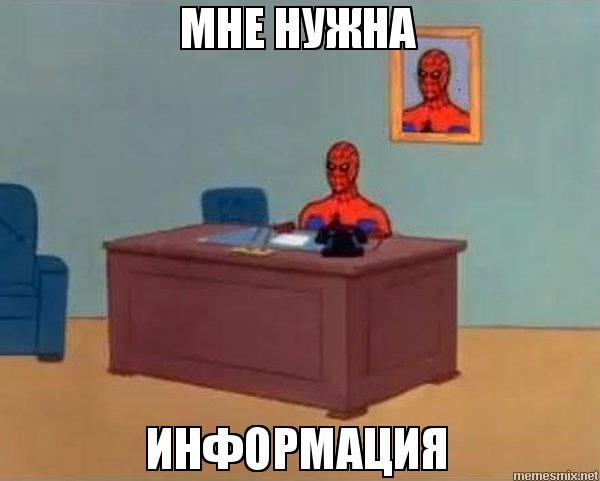

In [3]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
checks = checks.rename(columns={'student_id':'id'})
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [6]:
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [7]:
active_studs = active_studs.rename(columns={'student_id':'id'})
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [8]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


 <br><br><h2>Определим метрики на которые необходимо посмотреть во время анализа:</h2><br><br>

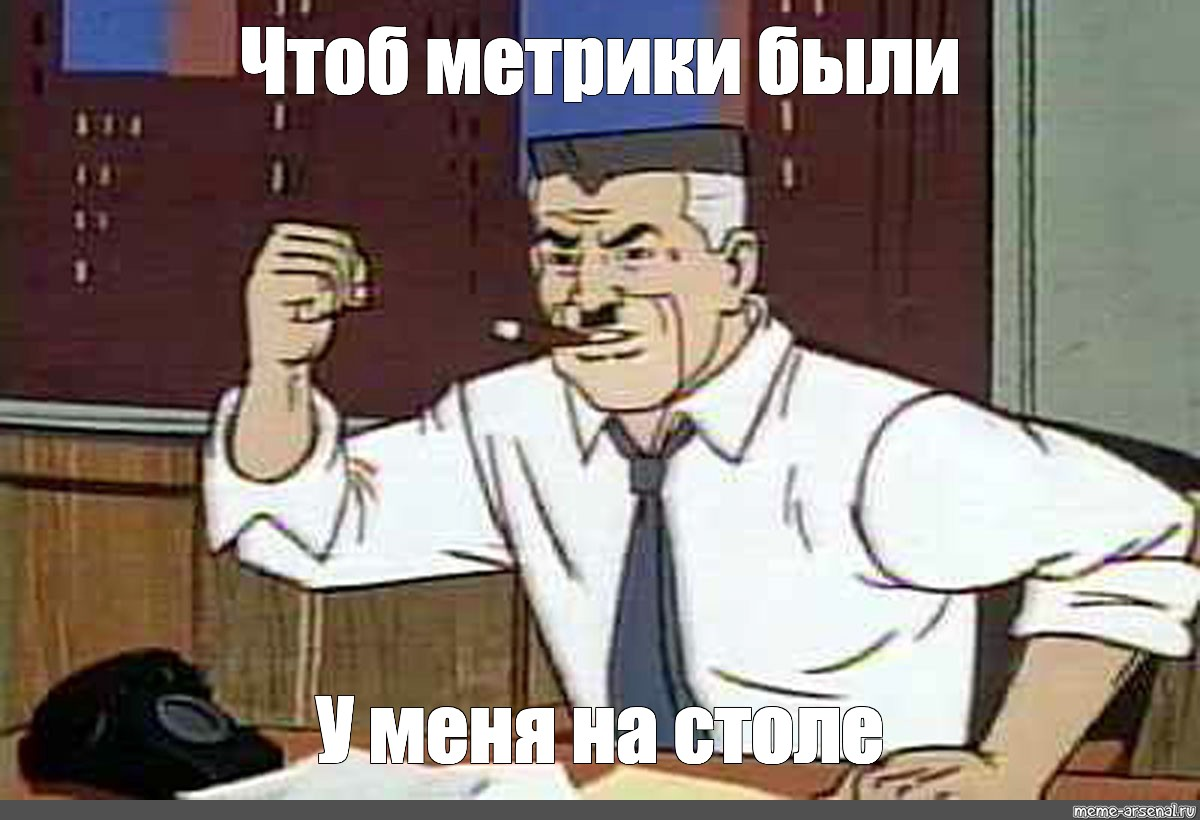

У нас есть определенный период исследования.
Мы знаем не так и много всего: количество пользователей в тестовой группе, количество активных пользователей ( пользователи которые зашли на сайт ) и сумму потраченную на товар:
 <br>=> мы можем использовать такие метрики:<br>
 <br>
 <br><b>CR в посетитель</b> (отношение колличества активных юзеров на всех юзеров в тесте);
 <br><b>СR посетитель в покупку</b> (отношение активных пользователей в покупку);
 <br><b>ARPU</b> (отношение общего дохода к числу пользователей участвующих в тесте);
 <br><b>ARPAU</b> (отношение общего дохода к числу активных пользователей).
 <br> (активный пользователь - это тот кто перешел на сайт из тестовой группы)<br>
 <br>Также можно посмотреть и средний чек, максимальный чек, суммарный чек, а также колличество покупок.

<h2>Для начала давайте объединим таблицы и расчитаем средний чек, максимальный чек, количество покупок</h2> <br><br>

Метод объединения inner так как нужно знать только тех юзеров, которые были выбранны как "тестировщики".

In [9]:
by_chek    = checks.merge(groups, on='id') # юзеры которые совершили покупку с их чеком

mean_chek  = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.mean}).rename(columns={'rev':'mean_ch'}) # стредний чек
max_chek   = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.max}).rename(columns={'rev':'max_ch'}) # максимальный чек
count_chek = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.count}).rename(columns={'rev':'count_ch'}) # кооличество чеков
sum_chek   = by_chek.groupby('grp',as_index=False).agg({'rev':pd.Series.sum}).rename(columns={'rev':'sum_ch'}) # суммарный чек

join_table_chek = mean_chek.merge(max_chek,on='grp').merge(count_chek,on='grp').merge(sum_chek,on='grp') # сводная

join_table_chek

,grp,mean_ch,max_ch,count_ch,sum_ch
0,A,860.710280,3660.0,107.0,92096.0000
1,B,1106.997699,4650.0,433.0,479330.0036


In [10]:
# выводим значения

print('Разница между количеством покупок:', join_table_chek.query("grp=='B'")['count_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['count_ch'][0])

print('Разница между средними чеком:', round(join_table_chek.query("grp=='B'")['mean_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['mean_ch'][0],2))

print('Разница между максимальным чеком:', join_table_chek.query("grp=='B'")['max_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['max_ch'][0])

print('Разница между суммарным чеком:', round(join_table_chek.query("grp=='B'")['sum_ch'][1]\
                                            -join_table_chek.query("grp=='A'")['sum_ch'][0],2))

Разница между количеством покупок: 326.0
Разница между средними чеком: 246.29
Разница между максимальным чеком: 990.0
Разница между суммарным чеком: 387234.0


Построим Box граффики для визуализации

In [ ]:
fig1 = go.Figure()

fig1.add_trace(go.Box(y = by_chek.query("grp=='A'").rev, name='Sample A',
                     marker_color = 'indianred'))

fig1.add_trace(go.Box(y = by_chek.query("grp=='B'").rev, name = 'Sample B',
                     marker_color = 'lightseagreen'))

fig1.show()

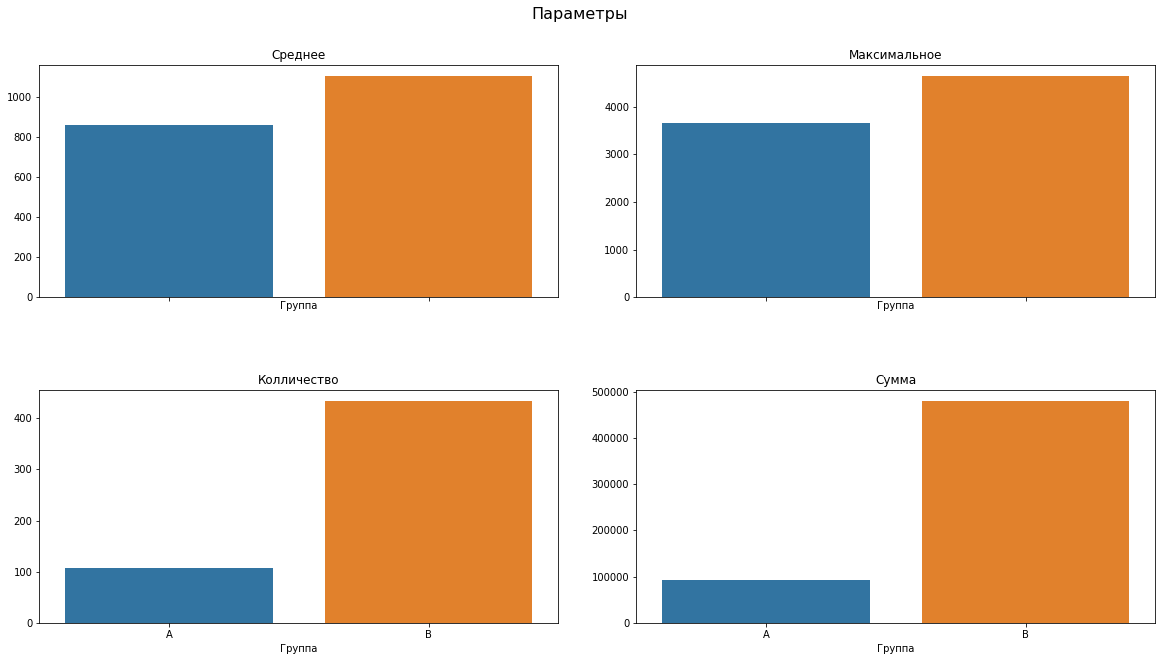

In [13]:
melt_table_for_plot = join_table_chek.melt(id_vars='grp')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.15)

columns=join_table_chek.columns
columns=columns.drop(['grp'])

fig.suptitle('Параметры', fontsize=16)
for ax,name,col in zip(axes.flatten(),['Cреднее','Максимальное','Колличество','Сумма'],columns):
    sb.barplot(data=join_table_chek,x=join_table_chek.grp, y=join_table_chek[col], ax=ax)
    ax.set(ylabel='', xlabel='Группа', title=name)
    
plt.subplots_adjust(top=0.9)

Как можно увидеть из граффика и получившимися показателями, что чаще всего покупали люди попавшие в эксперемернтальной греппе.<br>
Делать вывод только по графику – не очень хорошо, проведем статистический теста, чтобы определить, взаимосвязь между группами есть.
Для начала выдвенем гипотезу: чеки распределенны по нормальному закону?
для этого применем критерий 

In [20]:
print(st.shapiro(by_chek.query("grp=='A'").rev))
print(st.shapiro(by_chek.query("grp=='B'").rev))

ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13)
ShapiroResult(statistic=0.867313027381897, pvalue=9.542798088039443e-19)


Отклоняем нулевую гипотезу и принимаем, что распределены чеки по нормальному закону. 
<br>Проведем тест Манна-Уитни и будстрепом по среднему для сравнии средних. Критерий отклонения нулевой гипотезы принемаем стандатным = 0.05.

In [21]:
p1   = st.mannwhitneyu(by_chek.query("grp=='A'").rev,by_chek.query("grp=='B'").rev)
t    = funBood.get_bootstrap(by_chek.query("grp=='A'").rev,by_chek.query("grp=='B'").rev)
resh = t["p_value"]

print('p-value при Bootstrap (среднее):', t["p_value"],
     '\np-value при mannwhitneyu:', p1[1])

if p1[1]<0.05 or resh<0.05:
    print('')
    print('Отклоняем нулевую гепотезу.' )
    print('Взаимосвязь между группами есть.')
    
else:
    print('')
    print('Принимаем нулевую гепотезу.')
    print('Взаимосвязи между группами нет.')


p-value при Bootstrap (среднее): 3.5439734678452536e-06 
p-value при mannwhitneyu: 0.00021019690333618245

Отклоняем нулевую гепотезу.
Взаимосвязь между группами есть


Вроде как успех! Анализ показал стат.значимые различия между группами. В группе В выше средний чек. Положительный сигнал. <b>Но не спешим и проверим наши метрики.
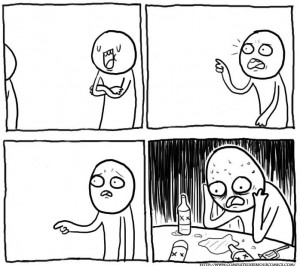

<b>Определим количество колличество активынх пользователей у каждой группы и рассичтаем метрики (СR, ARPU)</b>

In [37]:
activ_user = active_studs.merge(groups, on='id')
grp_activ  = activ_user.groupby('grp',as_index=False).agg({'id':pd.Series.count}).rename(columns={'id':'users'})

print('Разница между количеством активных пользователей:', grp_activ.query("grp=='B'")['users'][1]\
                                                           -grp_activ.query("grp=='A'")['users'][0])

Разница между количеством активных пользователей: 5258


In [38]:
fig1 = px.histogram(grp_activ , x="grp",y = 'users')
fig1.show()

Также можно увидеть что колличество активынх пользователей больше у эксперемента.
Неужели это успех?<br>
Проверим колличество пользователей у контрольной и у эксперементальной группы.

In [39]:
print('Контрольная группа:', groups.query("grp=='A'").id.count(),\
      ', процент от общего колличества: ', groups.query("grp=='A'").id.count()/groups.id.count()*100,'%')

print('Эксперементальная группа:', groups.query("grp=='B'").id.count(),\
      ', процент от общего колличества: ', groups.query("grp=='B'").id.count()/groups.id.count()*100,'%')

Контрольная группа: 14671 , процент от общего колличества:  19.69684764513184 %
Эксперементальная группа: 59813 , процент от общего колличества:  80.30315235486816 %


Как оказалось, что эксперементальная группа больше чем контрольная. <br>
Используем критерии Пирсона (критерий хи-квадрат), так как переменные у нас категориальные.<br>
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть <br>

Проверим две гипотезы:<br>
1.Есть ли взаимосвязь между активностью пользователей?<br>
2.Есть ли взаимосвязь между переходами в покупку активных пользователей?

In [40]:
ToF_act = activ_user.merge(groups,on='id',how='right')
ToF_act['TF']=ToF_act.grp_x.notna()

ToF_act 

,id,grp_x,grp_y,TF
0,1489,NaN,B,False
1,1627,A,A,True
2,1768,NaN,B,False
3,1783,NaN,B,False
4,1794,NaN,A,False
...,...,...,...,...
74479,5692459,NaN,B,False
74480,5692572,NaN,B,False
74481,5692865,NaN,B,False
74482,5693667,NaN,B,False


На предыдущем шаге добавил новую переменную которая показывает был ли участьник теста активен или нет.<br>
Для этого использовал присоединение outer.<br>
Также определим новую переменную для активных пользователей, которые перешли к покупке.

In [41]:
ToF       = checks.merge(activ_user,on='id',how='outer')
ToF['TF'] = ToF.rev.isna()
ToF       =ToF.dropna(subset=['grp'])

ToF

,id,rev,grp,TF
0,1627,990.0000,A,False
4,100300,990.0000,B,False
8,108270,290.0000,B,False
26,264473,1900.0001,B,False
27,274352,690.0000,B,False
...,...,...,...,...
8473,264371,NaN,B,True
8474,1794344,NaN,B,True
8475,296883,NaN,B,True
8476,3598448,NaN,B,True


Проводим тест

In [42]:
value_act = st.chi2_contingency(pd.crosstab(ToF_act.grp_y, ToF_act.TF))
value_by  = st.chi2_contingency(pd.crosstab(ToF.grp, ToF.TF))

pvalue_act = value_act[1]
pvalue_by  = value_by[1]

print ('Пи-значение при сравнении активности:',pvalue_act)

if pvalue_act <= 0.05:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')
    
print('')

print ('Пи-значение при сравнении покупок:   ',pvalue_by)
    
if pvalue_by  <= 0.05:
    print('Отклоняем H0')
else:
    print('Принимаем H0')

Пи-значение при сравнении активности: 0.002173404736900965
Отклоняем H0

Пи-значение при сравнении покупок:    0.46803677583199144
Принимаем H0


Так! Получается, что статистических значимых различий нет при анализе покупок. Проверим на метриках!

<b>Посчитаем метрики!</b> <br><br>
Для этого я создал функции расчета метрик.

In [43]:
def CR (grop):
    
    CR_active             = round(activ_user.query("grp==@grop").id.count()/groups.query("grp==@grop").id.count(),2)*100
    CR_active_bying_abs   = round(by_chek.query("grp==@grop").id.count()/groups.query("grp==@grop").id.count(),2)*100
    CR_active_bying_otnos = round(by_chek.query("grp==@grop").id.count()/activ_user.query("grp==@grop").id.count(),2)*100
    
    return CR_active,CR_active_bying_abs,CR_active_bying_otnos

def ARPU (grop):
    
    ARPU  = round(by_chek.query("grp==@grop").rev.sum()/groups.query("grp==@grop").id.count(),2)
    ARPAU = round(by_chek.query("grp==@grop").rev.sum()/activ_user.query("grp==@grop").id.count(),2)
    
    return ARPU,ARPAU

In [44]:
group = ['A','B']
ARPU_A = ARPU('A')
ARPU_B = ARPU('B') 

CR_A  = CR('A')
CR_B  = CR('B')

df = pd.DataFrame(columns=['Группа','CR в посетитель','СR посетитель в покупку','CR посетитель в покупку (относительно активного пользователя)','ARPU','ARPAU'])

CR_active             = [CR_A[0],CR_B[0]]
CR_active_bying_abs   = [CR_A[1],CR_B[1]]
CR_active_bying_otnos = [CR_A[2],CR_B[2]]

ARPU  = [ARPU_A[0],ARPU_B[0]]
ARPAU = [ARPU_A[1],ARPU_B[1]]

df['Группа'] = group
df['CR в посетитель'] = CR_active
df['СR посетитель в покупку'] = CR_active_bying_abs 
df['CR посетитель в покупку (относительно активного пользователя)'] = CR_active_bying_otnos
df['ARPU'] = ARPU
df['ARPAU'] = ARPAU

df

,Группа,CR в посетитель,СR посетитель в покупку,CR посетитель в покупку (относительно активного пользователя),ARPU,ARPAU
0,A,10.0,1.0,7.0,6.28,60.00
1,B,11.0,1.0,6.0,8.01,70.56


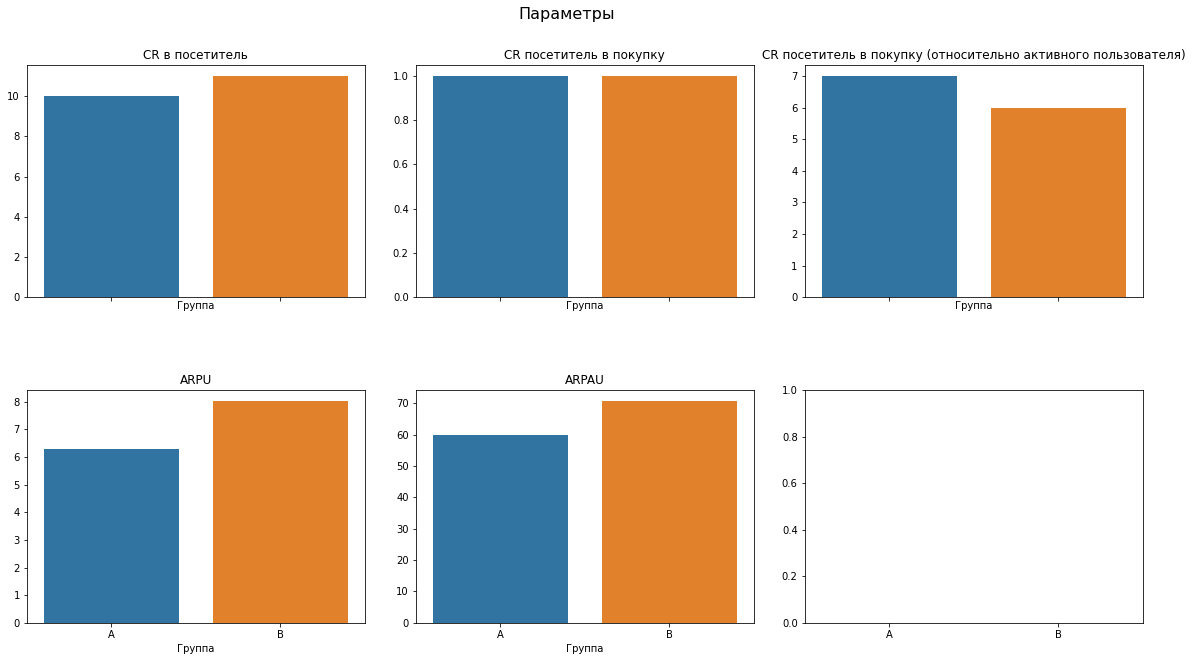

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.15)

columns=df.columns
columns=columns.drop(['Группа'])

fig.suptitle('Параметры', fontsize=16)
for ax,name,col in zip(axes.flatten(),['CR в посетитель','СR посетитель в покупку',\
                                       'CR посетитель в покупку (относительно активного пользователя)',\
                                       'ARPU','ARPAU'],columns):
    sb.barplot(data=df,x=df['Группа'], y=df[col], ax=ax)
    ax.set(ylabel='', xlabel='Группа', title=name)
    
plt.subplots_adjust(top=0.9)

Изходя из тестов, показателей и граффиков можно сделать <b>вывод</b>:

1. Значимых разлиций между покупками не обнаружено (различия статистически незначимы). Возможно виной стоит то что, тест был проведен не корректно, т.к. в тесте колличество эксперементальной группы намного больше, чем контрольная. (Контрольная группа: 14671 , процент от общего колличества:  19.69684764513184 %. Эксперементальная группа: 59813 , процент от общего колличества:  80.30315235486816 %) вызывает подозрение уже (провести тест ~ поровну пользователей). Возможно новый формат оплаты не особо цепляет посетителе сайта (ARPAU всего на 10% происходит повышение). Возможно количество дней "кручения" теста не значительное.<br>
Предлагаю сделать новый тест, где используется равное колличество пользователей, "кручение" теста происходит месяц и каждый день записывется показания.<br><br>
2. Хотя показатели по чекам в эксперементальной группе выше чем у тестовой, я бы не рекомендовал использовать новую технологию оплаты на сайте ( различия между метриками оказались не значительными ).<br><br>
3. Как по мне нехватает деталей изменения!

Главный вопрос: <h1>Стоит ли запускать новую механику на всех пользователей?
    <h3>Мой ответ: Не нужно, отактываем на старую механику или проводим еще раз тест, но с большим временем и с большим деталей изменения или доделываем новую механнику и проводим новый A/B тест заного.<br>
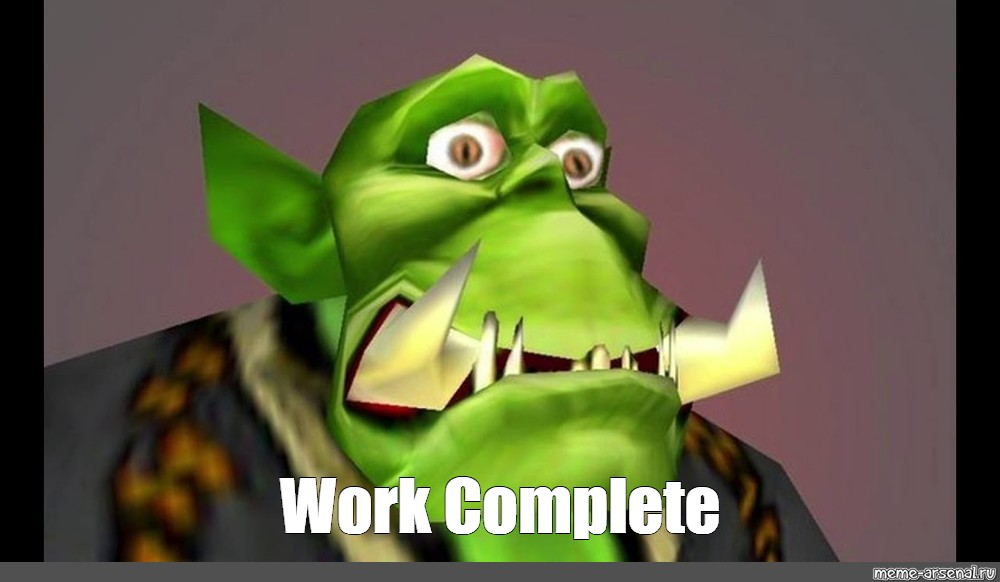